In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats

C:\Users\agrog\AppData\Local\Temp\ipykernel_9680\705250060.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Li, Bramley, & Gureckis (2021)
===

Trying to recreate the suspense modelling from Li, Bramley, and Gureckis (2021).

I'll copy over some of their code from OSF ([link](https://osf.io/zsjk8)), and rewrite some for my own clarity

The minimal amount to get their code working and simulating suspense is:
- A belief model: the player's perceived probability of success
- A suspense model: the metric that quantifies suspense as a function of belief

Notes:

- The authors are inconsistent in whether the bust condition is inclusive of bounds: sometimes they count 21 as bust, sometimes they dont
  - Here, we'll follow the blackjack rule of 21 is *not* bust, to keep understanding consistent for players

In [2]:
# Generate a sequence of pairs

def genPairSequence(theGame: dict) -> dict:
    """
    Each round, the deck is shuffled and 2 cards are produced and shown to the player. This function generates a list of those 2 cards shown per round.
    Of those 2 cards, the first (i.e. that at index 0) is the true card that the player will draw - which seems random to them but is in fact predetermined based on the suspense model.

    Inputs:
        - theGame (dict): Key-value object that stores game data and parameters
    Returns:
        - theGame (dict): Same as input with the addition of `pairSequence` key containing the list of card pairs, and `isWin` indicating if the card pair sequence would result in a win
    """
    # Deconstruct into upper and lower bounds
    upperBound, lowerBound = theGame['bounds']

    # Define callbacks that we'll use to check if the player is bust or not
    if theGame['isBust']:
        # Check if score is above upperBound or below lowerBound
        gameDone = lambda x: x > upperBound or x < lowerBound # i.e. not bust is not inclusive of bounds
    else:
        gameDone = lambda x: False

    pairSequence = []
    for n in range(theGame['nmax']):
        # Sample from the deck twice, without replacement - i.e. draw 2 unique cards (although their value CAN be equal)
        pairSequence.append(np.random.choice(theGame['deck'], 2, replace=False))

        # Check if the player is bust after drawing a new pair - note that they'll always get the first card in the pair as it's fixed
        if gameDone(sum(p[0] for p in pairSequence)):
            print('Bust')
            break

    theGame['pairSequence'] = np.array(pairSequence)
    theGame['isWin'] = checkIfWon([pr[0] for pr in pairSequence], theGame)

    return theGame

def checkIfWon(cards: list, theGame: dict) -> int:
    """
    Given the current list of cards, check if the player has gone bust.
    Inputs:
        - cards (list): A list of the cards drawn by the player, of max length `theGame[nmax]`
        - theGame (dict): The key-val obj that tracks game data and parameters
    Returns (int):
        - -1 for lost now
        - +1 for won now
        - 0 for other

    Note that elsewhere, the authors use 0/1/0.5 for lost/win/unknown

    """
    # Deconstruct bounds
    upperBound, lowerBound = theGame['bounds']
    # Check if the player is bust - NB: this counts bust as inclusive of the upperBound, unlike in actual Blackjack
    bust = (sum(cards) > upperBound) or (sum(cards) < lowerBound)
    # Define a default value for if they haven't won or lost yet
    outcome = 0

    if bust:
        # if the player is bust, or if they've exceeded the max number of draws
        # I have a feeling this check is actually redundant, but I'll leave it in for consistency with the authors' code
        if theGame['isBust'] or (not theGame['isBust'] and len(cards) == theGame['nmax']):
            # Lost
            outcome = -1
    else:
        # If all cards have been drawn without going bust
        if len(cards) == theGame['nmax']:
            # Win
            outcome = 1

    return outcome


In [3]:
# --- Belief models ---

def getWinProbability(theGame: dict) -> dict:
    """
    Compute the probability of winning for every card drawn

    This generates a list called `probOfWinning`, which is indexed with:
        - how many cards you have left to draw
        - your current score (the series index)
    and returns the probability of winning.

    Eg: If you have drawn 1 card, and have 4 cards remaining, look at probOfWinning[4].
    This has indices of minimumScore -> maximumScore, a list of all scores you may have from your first draw.
    If you drew a -3 on your first hand, then probOfWinning[4][-3] is the probability you'll win overall
    
    Eg 2: If you have drawn 4 cards and have 1 card remnaining, and your total score is 3, your probability of winning is:
    probOfWinning[1][3] = 1.0 :: since you can't draw a card greater than 18 (21-3=18).

    Inputs:
        - theGame (dict): Key-value object that stores game data and parameters
    Returns:
        - theGame (dict): same as input with the aforementioned `probOfWinning` array included.
    """
    # Create some local references to params
    nmax = theGame['nmax']
    upperBound, lowerBound = theGame['bounds']
    isBust = theGame['isBust']
    # Get all unique-valued cards in deck, and return the number of occurences of each value
    uniqueCards, cardCounts = np.unique(theGame['deck'], return_counts=True)
    # Compute probability of drawing each valued card
    cardProbabilities = cardCounts/sum(cardCounts)
    # Generate the probability distribution over the current deck
    probabilityDist = generateDistribution(theGame)
    # Define a structure for storing probability of winning after drawing the i'th card
    probOfWinning = [[] for kk in range(nmax + 1)]

    # Make a list of all possible scores
    possibleScores = np.arange(min(uniqueCards)*nmax, max(uniqueCards)*nmax+1)
    # From the possible scores, compute which are within bounds and allowed (1) and which are out of bounds (0)
    canWin = [int(score < upperBound and score > lowerBound) for score in possibleScores]
    probOfWinning[0] = pd.Series(canWin, index=possibleScores)


    for nmore in range(1, nmax+1):
        N = nmax - nmore
        # Again compute all possible scores from here
        possibleScores = np.arange(min(uniqueCards)*N, max(uniqueCards)*N+1)
        pWin = []
        # iterate over all possible scores
        for score in possibleScores:
            # Check bust condition
            if isBust:
                if score > upperBound or score < lowerBound:
                    pWin.append(0)
                    continue
                else:
                    probOfWin = 0
                    for ix, cardVal in enumerate(uniqueCards):
                        # sum the probabilities of drawing card ix and times by if this is within bounds (i.e. 0 or 1)
                        probOfWin += cardProbabilities[ix] * probOfWinning[nmore-1][score + cardVal]
                    pWin.append(probOfWin)
            else:
                # compute the probability of the sum of all remaining cards
                psum = probabilityDist[nmore-1] # the probability distribution given the remaining possible draws
                # for each possible remaining score that can be obtained, check if current score + poss remaining score is within bounds
                thisProb = max(
                                min(
                                    sum(
                                        [psum[smr] for smr in psum.index.values if score + smr < upperBound and score + smr > lowerBound]), 
                                    1), 
                                0)
                pWin.append(thisProb)
        # and store computed probabilities
        probOfWinning[nmore] = pd.Series(pWin, index=possibleScores)
        
    # Note that probOfWinning is indexed by number of remaining cards, not number drawn so far
    theGame['probOfWinning'] = probOfWinning

    return theGame


def generateDistribution(theGame: dict) -> list:
    """
    Produces a probability distribution of all possible scores under the given deck of cards
    Returns a list of pandas series, indexed by the draw number - 1

    Inputs:
        - theGame (dict): Key-value object that stores game data and parameters
    Returns:
        - list of type pd.Series containing all possible scores from the deck provided in input `theGame`
    """
    nmax = theGame['nmax']
    uniqueCards, cardCounts = np.unique(theGame['deck'], return_counts=True)
    cardProbabilities = cardCounts/sum(cardCounts)
    sumProbs = []
    sumProbs.append(pd.Series(cardProbabilities, index=uniqueCards))

    # Starting from 2 drawn cards, up to and inlcuding the maximum num that can be drawn
    for N in range(2, nmax+1):
        # Compute the lowest and highest possible values, and arange as a list of the values inbetween
        possibleScores = np.arange(min(uniqueCards)*N, max(uniqueCards)*N+1)
        # Create a pandas series of structure final-score : 0.0
        psum = pd.Series(np.zeros(len(possibleScores)), index=possibleScores)
        # Take the probabilities of drawing the card at the previous time step:
        psum0 = sumProbs[N-2]

        # --- For each possible total score after drawing N hands, compute the probability of getting that score ---
        # Iterate over all unique values that could be drawn
        for ix, cardVal in enumerate(uniqueCards):
            # iterate over the probability sums at the previous timestep (i.e. card draw)
            for x0 in psum0.index.values:
                psum[cardVal+x0] += psum0[x0]*cardProbabilities[ix]

        # Store the new probability sums 
        sumProbs.append(psum)

    return sumProbs

In [4]:
## -- Some helper functions -- ##

def beliefProbability(currentCard: int, prevCards: list, theGame: dict) -> float:
    """
    The belief that the player will immediately win

    Inputs:
        - currentCard: the value of the current (comparison) card
        - prevCards: A 1D list of the previously drawn card values
        - theGame: dict of all game data

    NB: the checkIfWon() function gives win/lose/unknown as 1/-1/0, 
    and here we transform it into 1/0/0.5
    """
    return (checkIfWon(prevCards + [currentCard], theGame) + 1)/2

def computeEntropy(p1: float, base: float=None) -> float:
    """
    Computes the Shannon entropy using scipy.stats.entropy routine.
    ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

    Inputs:
        - p1 (float): probability/ies used to define the discrete distribution
        - base (float) [default=None]: The logarithmic base to use. The default base=None will use the natural logarithm.

    Returns:
        - (float), the computed entropy
    """
    p1 = np.round(p1, 4)
    if np.size(p1) == 1:
        pdis = [p1, 1-p1]
    else:
        pdis = p1
    return stats.entropy(pdis, base=base)

In [5]:
# Compute suspense

def computeSuspense(theGame: dict, suspenseModels: list = ['cardDifference', 'infoGain', 'full']) -> dict:
    """
    Wrapper for iterating over all specified models of suspense and computing the suspenses for each.
    Stores the lists in a dict within `theGame`, key: 'suspenses'.

    Inputs:
        - theGame (dict): Key-value object that stores game data and parameters
        - suspenseModels (list): A list containing the names of the suspense models to use. Default uses `cardDifference`, `infoGain`, and `full`.
    Returns:
        - (dict): same as input `theGame` but including new dict indexed `suspenses` with the suspense values per card draw per model.
    """
    # If the probabilities of winning haven't been computed, do so
    if 'probOfWinning' not in theGame:
        theGame = getWinProbability(theGame)
    
    # Get local ref to the card pairs
    pairs = theGame['pairSequence']

    # Make a dict to store the suspense sequences for each suspense model
    suspenses = {}
    for model in suspenseModels:
        # Initialise with a list of length number of cards
        suspenses[model] = [[] for k in range(len(pairs))]

    # ---- Compute suspense for each model ---- #
        
    # For each card to be played
    for n in range(len(pairs)):
        pair = pairs[n]
        for model in suspenseModels:
            suspenses[model][n] = suspenseFns(pair, pairs[:n, 0], model, theGame)
    
    theGame['suspense'] = suspenses

    return theGame

def computeHybridSuspense(theGame: dict, hybridModelWeights: dict) -> dict:
    """
    Creates a weighted sum of suspense values from multiple different suspense models per card draw

    Inputs:
        - theGame (dict): Game settings and data dict
        - hybridModelWeights (dict): A mapping of model type to weighting in the linear combination. Eg:
            hybridModelWeights = {'uncertainty': 0.3, 'L1': 0.7}.
          These weights should sum to 1.
    """
    newSuspense = np.zeros(len(theGame['pairSequence']))
    for model, weight in hybridModelWeights.items():
        newSuspense += np.array(theGame['suspense'][model])*weight

    theGame['suspense']['hybrid'] = newSuspense

    return theGame

def suspenseFns(pair: list, prevCards: list, model: str, theGame: dict) -> list:
    # get bounds
    upperBound, lowerBound = theGame['bounds']
    probOfWinning = theGame['probOfWinning']
    nmore = theGame['nmax'] - len(prevCards)
    currentScore = sum(prevCards)

    # Check model type and compute suspense based on that model
    # model types are: winnow, carddiff, tobnd, plose, almostlose, uncertainty, infogain, L2, L1, L1biased, KL, Hellinger

    if model == "winNow":
        ## The probability that the player will win immediately, given the current cards
        ## This is Ely suspense on the belief that they'll win immediately
        # Takes the two cards in front of them, computes the probability of winning for each, and takes the variance
        p0 = beliefProbability(pair[0], prevCards, theGame)
        p1 = beliefProbability(pair[1], prevCards, theGame)
        suspense = (p0 - p1)**2

    elif model == 'cardDifference':
        ## The ratio of the difference in comparison cards to the maximum difference
        maxDifference = max(theGame['deck']) - min(theGame['deck'])
        suspense = abs(pair[0] - pair[1])/maxDifference

    elif model == "toBoundary":
        ## Check which is closest to a boundary - i.e. either upper or lower bound - of the two cards
        suspense = np.min(
            [np.min(abs(pair - upperBound)), np.min(abs(pair - lowerBound))]
            )
        suspense = np.exp(-suspense/10) # NB: this prohibits the value from being 0

    else:
        # models using longer-term belief - set up the probabilities
        p0 = probOfWinning[nmore - 1][currentScore + pair[0]]
        p1 = probOfWinning[nmore - 1][currentScore + pair[1]]
        # Compute the win belief - rounded to either 1 or 0 - given the two cards drawn
        probabilityNow = int(0.5 * (p0 + p1)*1e5)/1e5 # I'm assuming the 1e5 is to reduce floating point errors

        if model == "probLose":
            ## Simply the opposite of the probability of winning
            suspense = 1 - probabilityNow
        
        elif model == "uncertainty":
            ## The Shannon entropy of the average win belief
            suspense = computeEntropy(probabilityNow) / computeEntropy(0.5) # Note, does this need to include the base? It's using base e as default

        elif model == "informationGain":
            suspense = (2 * computeEntropy(probabilityNow) - (computeEntropy(p0) + computeEntropy(p1)))
            maxSuspense = (2*computeEntropy(0.5) - (computeEntropy(0) + computeEntropy(1)))
            suspense = suspense/maxSuspense

        elif model == "L2":
            ## Ely suspense on complete beliefs
            suspense = (p0-p1)**2

        elif model == "L1":
            ## Ely suspense with L1 distance
            suspense = np.abs(p0-p1)

        elif model == "L1Biased":
            ## L1 distance with a weighting and offset
            p0s = 0.6*p0 + 0.2
            p1s = 0.6*p1 + 0.2
            suspense = np.abs(p0s-p1s)

        elif model == "KL":
            ## Kullback-Leibler divergence
            suspense = stats.entropy([p0, 1-p0], [probabilityNow, 1-probabilityNow]) + stats.entropy([p1, 1-p1], [probabilityNow, 1-probabilityNow])
            maxSuspense = stats.entropy([0, 1], [0.5, 0.5])*2
            suspense = suspense / maxSuspense

        elif model == "Hellinger":
            suspense = np.sqrt(np.sum(
                (np.sqrt([p0, 1-p0]) - np.sqrt([p1, 1-p1]))**2
            )) / (2**0.5)
            maxSuspense = 1
            suspense = suspense/maxSuspense

            # ... more suspenses can be inserted below
        
        else:
            raise ValueError(f"Suspense model name `{model}` not recognised.")

    return suspense



In [6]:
def plotSuspenseModelCardPair(theGame):
    """
    Creates a matplotlib plot of raw suspense values alongside score percentiles for each model included in theGame['suspense']
    """
    fig, axs = plt.subplots(2, 1, figsize=(6, 6))
    axs[0].set_ylabel("Suspense")
    axs[0].set_ylim(0, 1.2)
    axs[1].set_ylabel("Suspense Order")

    # Get the labels for each suspense model used
    suspenseModels = theGame['suspense'].keys()
    for model in suspenseModels:
        suspense = theGame['suspense'][model]
        axs[0].plot(suspense, '--o', label=model)
        axs[1].plot(theGame['suspenseOrder'][model], '--o', label=model)
        
    plt.legend()
    pairs = theGame['pairSequence']
    cards = [p[0] for p in pairs]
    for ax in axs:
        ax.set_xticks(np.arange(len(suspense)))
        ax.set_xticklabels([[list(np.cumsum(cards) - cards)[k], list(pairs[k])] for k in range(len(pairs))])

    axs[1].set_xlabel("Current sum, Next pair")
    bust = ["Total", "Bust"]
    title = f"Rule: {bust[theGame['isBust']]} {theGame['bounds']}"

    fig.suptitle(title)
    plt.show()
    

In [7]:
# Main
# ----------------------------------------------------
# ## Define game parameters
nmax = 5 # Maximum number of cards that can be drawn
deckSize = 9 # The size of the deck
allowedCards = np.arange(-9, 10) # The possible cards - NB: including negative values! - from which each real deck is sampled (not inclusive of upper bound hence 10)
# -----------------------------------------------------

# Define game parameter storage object
theGame = {
    'bounds' : [10, -100], # the upper and lower bounds of the game score - eg: over 21, the player goes bust,
    'nmax' : nmax,
    'deck' : np.random.choice(allowedCards, deckSize), # samples the allowed cards, `deckSize` times, with replacement
    'isBust' : True
    }

# Generate the sequence of card pairs
theGame = genPairSequence(theGame)
theGame['seenCards'] = [i[0] for i in theGame['pairSequence']]

# Compute the suspense for this game
theGame = computeSuspense(theGame,['L1', 'toBoundary'])

suspenseOrder = {}
# Order the scores by their percentile rank relative to the other suspense values in the list
# Ref: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.percentileofscore.html
for model, suspense in theGame['suspense'].items():
    suspenseOrder[model] = [stats.percentileofscore(suspense, s)/100*len(suspense) for s in suspense]
theGame['suspenseOrder'] = suspenseOrder

In [17]:
theGame.keys()

dict_keys(['bounds', 'nmax', 'deck', 'isBust', 'pairSequence', 'isWin', 'seenCards', 'probOfWinning', 'suspense', 'suspenseOrder'])

In [143]:
theGame['pairSequence'], theGame['seenCards'], theGame['suspense']['L1']

# Z-score normalise the suspense values
# In her dissertation, Maria uses Z-score norm but doesn't say what data the mean and SD are taken over? Need to check with Bastien
# For the meantime we'll take it over the sequence?




(array([[-9,  4],
        [-1, -9],
        [ 4, -9],
        [ 4,  8],
        [-1,  4]]),
 [-9, -1, 4, 4, -1],
 [0.36640755982319806,
  0.015089163237311465,
  0.012345679012345623,
  0.11111111111111116,
  0])

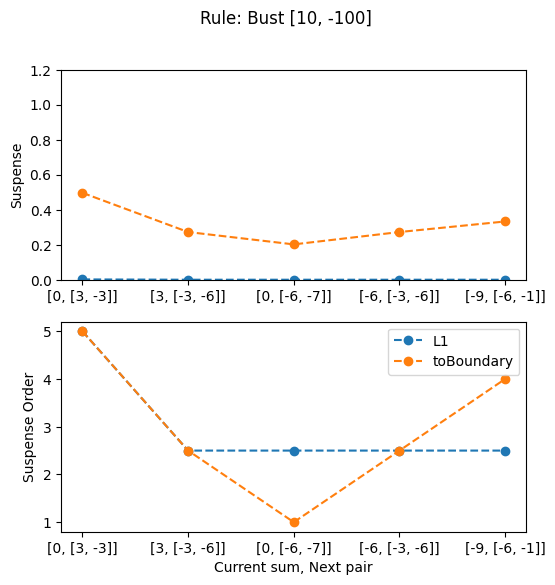

In [8]:
plotSuspenseModelCardPair(theGame)

[-1, -1, -1, -1, 9]


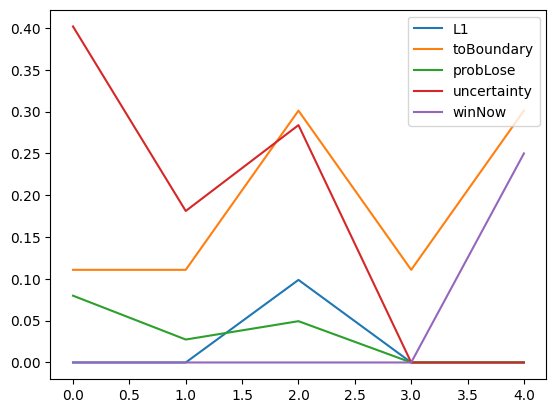

In [10]:
seenCards = [i[0] for i in theGame['pairSequence']]
print(seenCards)
for model in theGame['suspense']:
    plt.plot(list(range(len(theGame['seenCards']))), theGame['suspense'][model], label=model)
plt.legend()
plt.show()


In [ ]:
# TODO 
# - write some plotting functions that look like the original authors'
# - Add game filters as they do: find zero-suspense and large total suspense games
# - Find high suspense difference games
# - Avoid 'unfair' games

# Batch Generate Games

The following cell will create 5001 decks, each as a `theGame` dict, and saves it to a local pickle (this is done in the cell after FYI) - so don't run this every time as it takes a while, just load it from the existing pickle.

In [9]:
# ## Define game parameters
nmax = 5 # Maximum number of cards that can be drawn
deckSize = 9 # The size of the deck
allowedCards = np.arange(-9, 10) # The possible cards - NB: including negative values! - from which each real deck is sampled
bounds = [10, -100]
decks = [[1, 2, 3, 4, 5, 6, 7, 8, 9]]
# -----------------------------------------------------

# Define game parameter storage object
# theGame = {
#     'bounds' : [10, -100], # They set 10 as the upper bound in their generation notebook but I'm keeping it at 21 - no I'm not
#     'nmax' : nmax,
#     'deck' : np.random.choice(allowedCards, deckSize), # samples the allowed cards, `deckSize` times, with replacement
#     'isBust' : True
#     }

# Generate 5000 decks
for ksearch in range(5000):
    # From a single list containing 1-9 twice, sample `deckSize` times without replacement - thus allowing a max of 2 duplicates
    decks.append(np.random.choice(list(allowedCards)*2, deckSize, replace=False))

nGamesPerDeck = 1
allDecks = []

for deck in decks:
    deckGames = []
    for kgen in range(nGamesPerDeck):
        theGame = {'bounds' : bounds, 'nmax' : nmax, 'deck' : deck, 'isBust': False}
        # get sequence of pairs
        theGame = genPairSequence(theGame)
        theGame['seenCards'] = [i[0] for i in theGame['pairSequence']]
        # Compute the suspense for this game
        theGame = computeSuspense(theGame,['L1', 'toBoundary', 'probLose', 'uncertainty', 'winNow'])
        # Compute a hybrid suspense with uncertainty and L1 
        hybridWeights = {"uncertainty": 0.3, "L1" : 0.7}
        theGame = computeHybridSuspense(theGame, hybridWeights)

        # Order suspense by percentile
        suspenseOrder = {}
        for model, suspense in theGame['suspense'].items():
            suspenseOrder[model] = [stats.percentileofscore(suspense, s)/100*len(suspense) for s in suspense]
        theGame['suspenseOrder'] = suspenseOrder
        deckGames.append(theGame)
    allDecks.append(deckGames)

        

In [40]:
# Save the decks locally as pickle

import pickle

pickle.dump(allDecks, open('savedDecks/5001_decks.pickle', 'wb'))

# Filter Games

The decks are filtered by the following criteria:
- Disallow games where a card that appears only once in the deck appears more than 3 times in the draw sequence

In [24]:
import pickle

allDecks = pickle.load(open("savedDecks/5001_decks.pickle", 'rb'))

In [184]:
allDecks[0][0]['suspenseOrder']

{'L1': [5.0, 2.5, 2.5, 2.5, 2.5],
 'toBoundary': [1.0, 4.5, 4.5, 3.0, 2.0],
 'probLose': [1.0, 3.5, 3.5, 3.5, 3.5],
 'uncertainty': [5.0, 2.5, 2.5, 2.5, 2.5],
 'winNow': [3.0, 3.0, 3.0, 3.0, 3.0],
 'hybrid': [5.0, 2.5, 2.5, 2.5, 2.5]}

In [34]:
allDecks[0][0]['suspense']['toBoundary'], allDecks[0][0]['pairSequence']

([0.30119421191220214,
  0.2725317930340126,
  0.2465969639416065,
  0.20189651799465538,
  0.30119421191220214],
 array([[9, 3],
        [4, 8],
        [3, 7],
        [5, 4],
        [9, 5]]))

In [10]:
deckSize = 9
criteria = (1/deckSize)**3
def filterByRepeats(theGame):
    # Count the number of unique cards in the draw sequence, compared to the number of times they appear in the deck
    drawnCards, drawnCardCounts = np.unique(theGame['pairSequence'], return_counts=True)
    deckCards, deckCardCounts = np.unique(theGame['deck'], return_counts=True)

    for ix, card, in enumerate(drawnCards):
        pc = (deckCardCounts[deckCards==card]/deckSize)**drawnCardCounts[ix]

    for ix, pair in enumerate(theGame['pairSequence'][:-1]):
        if (pair == theGame['pairSequence'][ix+1]).all():
            return False
        
    return True

numDisallowed = 0
validGames = []
for deckGames in allDecks:
    for game in deckGames:
        if filterByRepeats(game):
            validGames.append(game)
        else:
            numDisallowed += 1

print(f"Filtering removed {numDisallowed} games.")

Filtering removed 373 games.


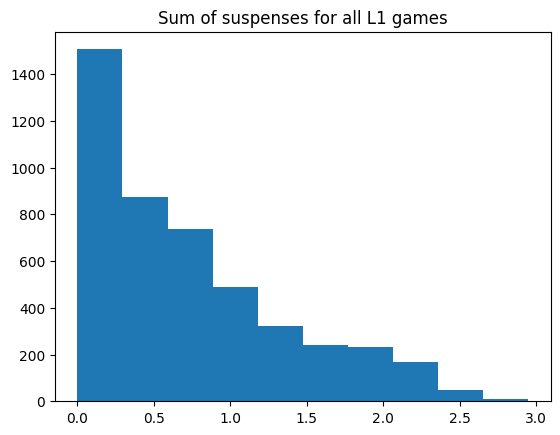

In [11]:
suspenseType = "L1"
allSuspenses = [np.sum(game['suspense'][suspenseType]) for game in validGames]
plt.hist(allSuspenses)
plt.title(f"Sum of suspenses for all {suspenseType} games")
plt.show()

In [38]:
step = 5
suspenseBin = np.percentile(allSuspenses, [0, 2*step, 50-step, 50+step, 98, 100])
gameBins = [[[], []] for k in range(3)]
for game in validGames:
    gameSuspense = np.sum(game['suspense'][suspenseType])
    gameLen = len(game['pairSequence'])
    for kbin in range(3):
        if gameSuspense >= suspenseBin[kbin*2] and gameSuspense <= suspenseBin[kbin*2+1] and gameLen >= 4:
            gameBins[kbin][game['isWin'] == 1].append(game)
print([len(b) for bins in gameBins for b in bins])

[0, 457, 33, 423, 41, 51]


# Get Highest and Lowest Ranked Games

In [12]:
# stats.percentileofscore(list, int)
# Rank by percentile
allSuspenses = [np.sum(game['suspense'][suspenseType]) for game in validGames]
suspensesRanked = {}
for ix, suspense in enumerate(allSuspenses):
    suspensesRanked[ix] = {
        "suspense" : suspense,
        "rank" : stats.percentileofscore(allSuspenses, suspense),
        **validGames[ix]
    }

# Convert to a dataframe for easier querying
df = pd.DataFrame.from_dict(suspensesRanked, orient="index")
df = df.sort_values(by="rank", ascending=True)



In [13]:
df.head()
# I want to get:
#   - Mean of all suspense values
#   - SD of all suspense values
#   - Z-score per suspense per round
#   - Average z-score per round

# df['meanL1'] = df['suspense']
# Get a separate entry for L1 norm
df['L1'] = df['suspense'].apply(lambda x: x['L1'])
# Compute the average and SD over all values
global_mean = np.mean(df.explode('L1')['L1'])
global_std = np.std(df.explode('L1')['L1'])
# Compute z-score per suspense value in a round
df['L1-Z'] = df['L1'].apply(lambda x: [(i-global_mean)/(global_std) for i in x])
df['L1-Z-mean'] = df['L1'].apply(lambda x: (np.mean(x)-global_mean)/global_std)

In [14]:
# Grab the bottom X and top X
bottomPercent = 1
topPercent = 0.5
medPercent = 0.25
bottom10 = df[:int(len(df)*bottomPercent/100)]
top5 = df[-int(len(df)*topPercent/100):]
# Get the middle of the scale and take 2.5% of the rounds either side
medium5Bounds = [int(len(df)*0.5)-int(len(df)*medPercent/100), int(len(df)*0.5)+int(len(df)*medPercent/100)]
medium5 = df[medium5Bounds[0]:medium5Bounds[1]]

In [15]:
df['L1'].apply(np.max)

2546    0.0
3951    0.0
2201    0.0
51      0.0
3828    0.0
       ... 
2934    1.0
4357    1.0
3976    1.0
2733    1.0
4350    1.0
Name: L1, Length: 4628, dtype: float64

In [226]:
medium5

,suspense,rank,bounds,nmax,deck,isBust,pairSequence,isWin,seenCards,probOfWinning,suspenseOrder,L1,L1-Z,L1-Z-mean
466,"{'L1': [0.09190672153635115, 0.119341563786008...",49.833887,"[10, -100]",5,"[8, 1, -8, -9, 9, 5, 3, 3, -5]",False,"[[8, 5], [5, 1], [5, 3], [3, -9], [-8, -5]]",-1,"[8, 5, 5, 3, -8]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [3.0, 4.0, 2.0, 5.0, 1.0], 'toBoundary'...","[0.09190672153635115, 0.11934156378600819, 0.0...","[-0.2703447288492997, -0.14547258751162337, -0...",-0.147970
881,"{'L1': [0.03170248437738149, 0.290809327846364...",49.944629,"[10, -100]",5,"[2, -3, 2, 7, -9, 5, 8, 4, 0]",False,"[[5, 4], [4, -3], [5, 0], [2, 7], [2, 4]]",-1,"[5, 4, 5, 2, 2]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [2.0, 5.0, 4.0, 3.0, 1.0], 'toBoundary'...","[0.03170248437738149, 0.2908093278463648, 0.16...","[-0.5443697056736455, 0.6349782958488549, 0.04...",-0.147831
144,"{'L1': [0.4791952446273433, 0.1152263374485597...",50.055371,"[10, -100]",5,"[-4, 9, -7, 2, 0, 2, 4, 8, -1]",False,"[[-4, 9], [-7, 0], [-4, 2], [9, 8], [-1, 4]]",1,"[-4, -7, -4, 9, -1]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [5.0, 4.0, 2.0, 2.0, 2.0], 'toBoundary'...","[0.4791952446273433, 0.1152263374485597, 0.0, ...","[1.492433666367567, -0.1642034087122745, -0.68...",-0.147554
340,"{'L1': [0.15028196921201042, 0.0, 0.1111111111...",50.166113,"[10, -100]",5,"[6, 3, 0, 4, 5, -1, -9, -1, -9]",False,"[[4, -1], [-9, -9], [6, 3], [-9, 5], [-9, -1]]",1,"[4, -9, 6, -9, -9]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [4.0, 1.5, 3.0, 5.0, 1.5], 'toBoundary'...","[0.15028196921201042, 0.0, 0.11111111111111105...","[-0.004644561447465456, -0.6886664023305161, -...",-0.147276


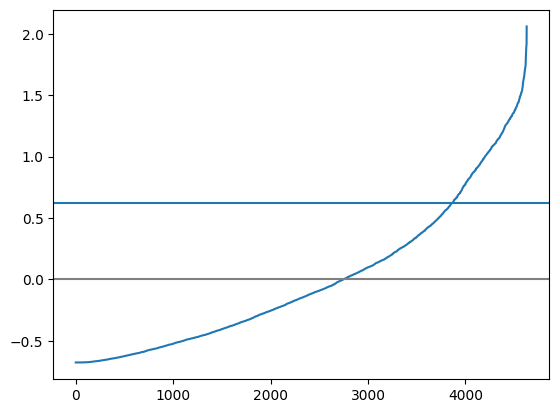

In [29]:
plt.plot(np.linspace(0, len(df), len(df)), df['L1-Z-mean'])
plt.axhline(0.0, color='grey')
plt.axhline(midpoint)
plt.show()

In [133]:
low_slice = df.head(8)
high_slice = df.tail(8)
# Find the midpoint between the 2
midpoint = np.mean(low_slice['L1-Z-mean']) + (np.mean(high_slice['L1-Z-mean']) - np.mean(low_slice['L1-Z-mean']))/2 # Is our true medium suspense
print(f"True suspense midpoint at {midpoint}")
# Get the true medium suspense values
mid_slice = df.query("`L1-Z-mean` >= 0.62").query("`L1-Z-mean` <= 0.63").tail(8)
# You can also insert the midpoint variable with @midpoint, but I want more manual control over the bounds here


True suspense midpoint at 0.6146540132427489


,suspense,rank,bounds,nmax,deck,isBust,pairSequence,isWin,seenCards,probOfWinning,suspenseOrder,L1,L1-Z,L1-Z-mean
708,"{'L1': [0.10120408474317943, 0.459533607681755...",83.556612,"[10, -100]",5,"[2, 9, 7, 5, -3, -8, -2, 0, -4]",False,"[[2, 5], [9, -3], [-2, -8], [5, -2], [-3, 0]]",-1,"[2, 9, -2, 5, -3]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [2.0, 4.0, 3.0, 5.0, 1.0], 'toBoundary'...","[0.10120408474317943, 0.45953360768175583, 0.2...","[-0.20635003072148744, 1.4568817722599172, 0.6...",0.623780
330,"{'L1': [0.269166285627191, 0.2441700960219479,...",83.578220,"[10, -100]",5,"[3, -7, -8, -1, 8, 2, 5, 7, -3]",False,"[[3, -7], [5, -1], [8, -8], [3, -1], [8, 3]]",-1,"[3, 5, 8, 3, 8]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [4.0, 3.0, 5.0, 2.0, 1.0], 'toBoundary'...","[0.269166285627191, 0.2441700960219479, 0.6666...","[0.5732677688895326, 0.4572447932668398, 2.418...",0.625620
2595,"{'L1': [0.19661636945587557, 0.119341563786008...",83.610631,"[10, -100]",5,"[5, 2, -8, 2, 8, -4, 6, 4, -6]",False,"[[2, -4], [2, 5], [4, -6], [-8, 5], [-8, 2]]",1,"[2, 2, 4, -8, -8]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [3.0, 2.0, 4.0, 5.0, 1.0], 'toBoundary'...","[0.19661636945587557, 0.11934156378600819, 0.4...","[0.23651815671635107, -0.12216262767819257, 1....",0.625761
4426,"{'L1': [0.09510745313214453, 0.480109739368998...",83.610631,"[10, -100]",5,"[8, 5, -1, -7, -1, 6, -8, -7, 7]",False,"[[8, 5], [6, -8], [5, -7], [7, -8], [6, -1]]",-1,"[8, 6, 5, 7, 6]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [2.0, 4.0, 5.0, 3.0, 1.0], 'toBoundary'...","[0.09510745313214453, 0.4801097393689985, 0.49...","[-0.23464831745872958, 1.5523884899981084, 1.6...",0.625761
1663,"{'L1': [0.16750495351318384, 0.347050754458161...",83.643042,"[10, -100]",5,"[0, 1, 8, 9, -1, -4, 7, 3, -6]",False,"[[-6, -1], [9, -1], [3, -4], [8, -1], [7, 8]]",-1,"[-6, 9, 3, 8, 7]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [2.0, 4.0, 3.0, 5.0, 1.0], 'toBoundary'...","[0.16750495351318384, 0.3470507544581618, 0.33...","[0.10139383754601969, 0.9347783819577999, 0.87...",0.626752
4176,"{'L1': [0.018899557994208283, 0.02743484224965...",83.664650,"[10, -100]",5,"[-8, -4, 0, -3, -1, 6, -6, 5, 4]",False,"[[-6, -4], [4, 0], [6, 5], [4, -1], [-8, 6]]",1,"[-6, 4, 6, 4, -8]","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'L1': [1.0, 3.0, 2.0, 4.0, 5.0], 'toBoundary'...","[0.018899557994208283, 0.027434842249657088, 0...","[-0.5883769016742557, -0.548759300242117, -0.5...",0.627600


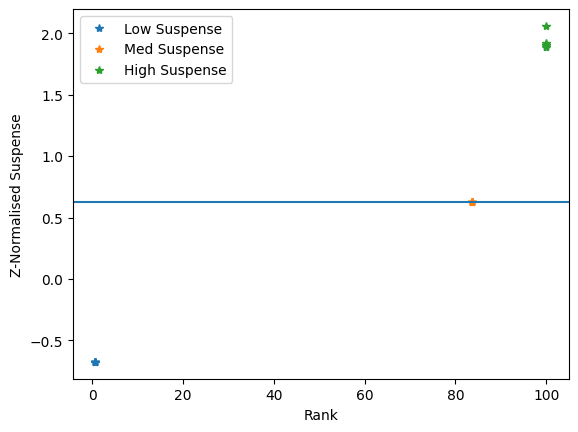

In [53]:
plt.plot(low_slice['rank'], low_slice['L1-Z-mean'], '*', label="Low Suspense")
plt.plot(mid_slice['rank'], mid_slice['L1-Z-mean'], '*', label="Med Suspense")
plt.plot(high_slice['rank'], high_slice['L1-Z-mean'], '*', label="High Suspense")
plt.axhline(midpoint)
plt.xlabel('Rank')
plt.ylabel('Z-Normalised Suspense')
plt.legend()
plt.show()

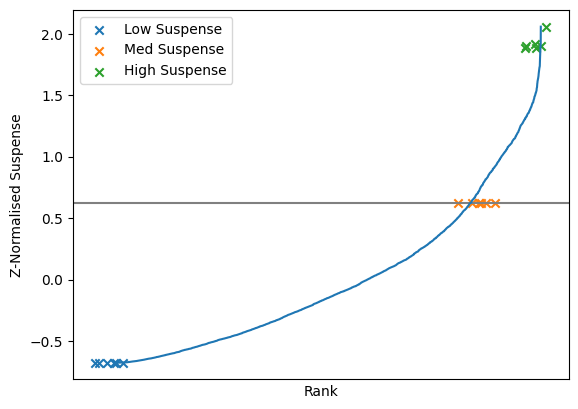

In [66]:
plt.scatter([1 + random.uniform(-0.1, 0.1)  for i in range(len(low_slice))], low_slice['L1-Z-mean'], marker='x', label="Low Suspense")
plt.scatter([2.7 + random.uniform(-0.1, 0.1)  for i in range(len(mid_slice))], mid_slice['L1-Z-mean'], marker='x', label="Med Suspense")
plt.scatter([3 + random.uniform(-0.1, 0.1)  for i in range(len(high_slice))], high_slice['L1-Z-mean'], marker='x', label="High Suspense")
slope = (np.max(high_slice['L1-Z-mean']) - np.min(low_slice['L1-Z-mean'])) / (3-1)
# plt.axline((1.0, np.min(low_slice['L1-Z-mean'])), slope=slope, color='grey')
plt.axhline(midpoint, color='grey')
plt.plot(np.linspace(1, 3, len(df)), df['L1-Z-mean'])
plt.xlabel('Rank')
plt.ylabel('Z-Normalised Suspense')
plt.tick_params(axis="x", bottom=False, labelbottom=False)
plt.xticks(None)
plt.legend()
plt.show()

In [139]:
# Save 3 dfs into jsons
low_slice.to_json("savedDecks/lowSus.json")
mid_slice.to_json("savedDecks/medSus.json")
high_slice.to_json("savedDecks/highSus.json")

In [87]:
def plotSingleSuspenseModelCardPair(theGame):
    """
    Creates a matplotlib plot of raw suspense values alongside score percentiles for each model included in theGame['suspense']
    """
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
    axs.set_ylabel("Suspense")
    axs.set_ylim(0, 1.2)

    suspense = theGame['suspense']['L1']
    axs.plot(suspense, '--o', label='L1')
        
    plt.legend()
    pairs = theGame['pairSequence']
    cards = [p[0] for p in pairs]
    axs.set_xticks(np.arange(len(suspense)))
    axs.set_xticklabels([[list(np.cumsum(cards) - cards)[k], list(pairs[k])] for k in range(len(pairs))])

    bust = ["Total", "Bust"]
    title = f"Rule: {bust[theGame['isBust']]} {theGame['bounds']}"

    fig.suptitle(title)
    plt.show()

In [107]:
5 // 3, 5%3

(1, 2)

[[<Axes: > <Axes: > <Axes: > <Axes: >]
 [<Axes: > <Axes: > <Axes: > <Axes: >]]


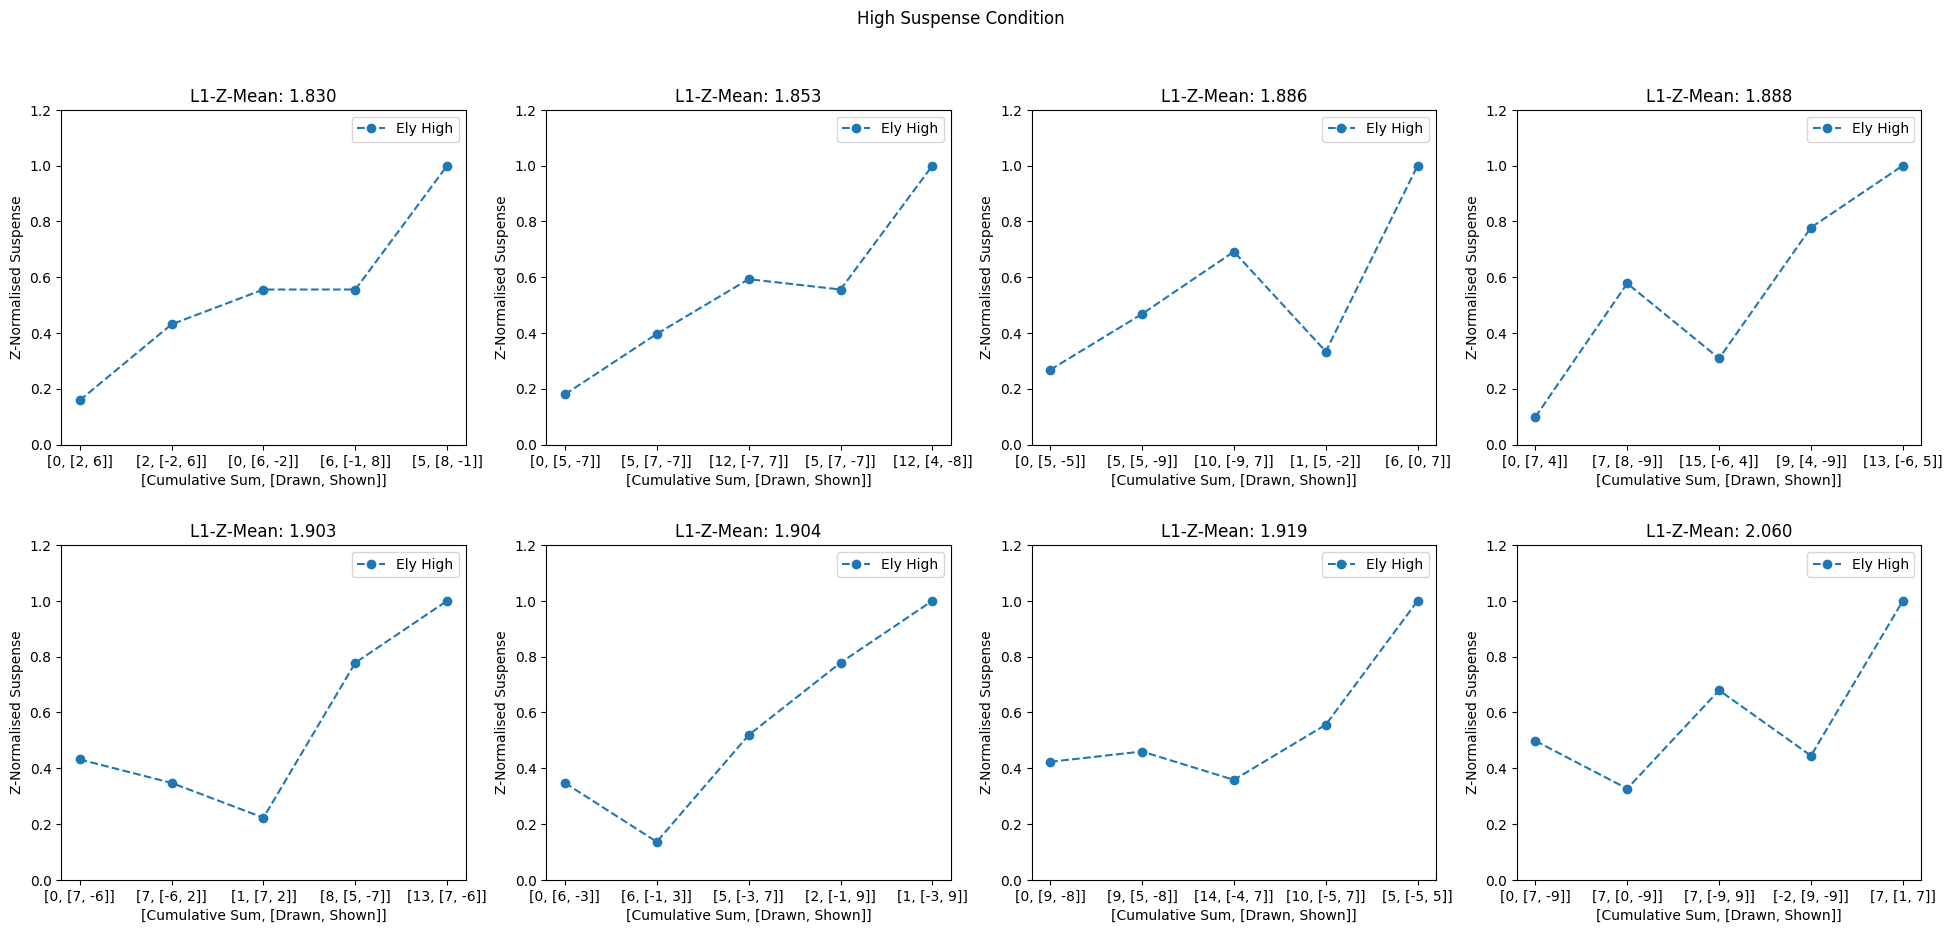

In [152]:
# Create a 3 plots of 2x3 for each mode:
# plotSuspenseModelCardPair(theGame)

use_slice = high_slice
alt_slice = high_slice

fig, axs = plt.subplots(2, 4, figsize=(24, 10))
plt.subplots_adjust(hspace=0.3)
# axs.set_ylabel("Suspense")
# axs.set_ylim(0, 1.2)
print(axs)

for i in range(0, 8):
    axs[i//4][i%4].set_ylim(0, 1.2)
    tg = use_slice.iloc[i].to_dict()
    tg2 = alt_slice.iloc[i].to_dict()
    axs[i//4][i%4].plot(tg['suspense']['L1'], '--o', label='Ely High',)
    # axs[i//4][i%4].plot(tg2['suspense']['L1'], '--o', label='Ely High',)
    pairs = tg['pairSequence']
    cards = [p[0] for p in pairs]
    axs[i//4][i%4].set_xticks(np.arange(len(tg['suspense']['L1'])))
    axs[i//4][i%4].set_xticklabels([[list(np.cumsum(cards) - cards)[k], list(pairs[k])] for k in range(len(pairs))])
    axs[i//4][i%4].set_title(f"L1-Z-Mean: {tg['L1-Z-mean']:.3f}")
    axs[i//4][i%4].set_xlabel("[Cumulative Sum, [Drawn, Shown]]")
    axs[i//4][i%4].set_ylabel("Z-Normalised Suspense")
    axs[i//4][i%4].legend()

    bust = ["Total", "Bust"]
    title = f"Rule: {bust[tg['isBust']]} {tg['bounds']}"

fig.suptitle("High Suspense Condition")

# plt.legend()

plt.show()


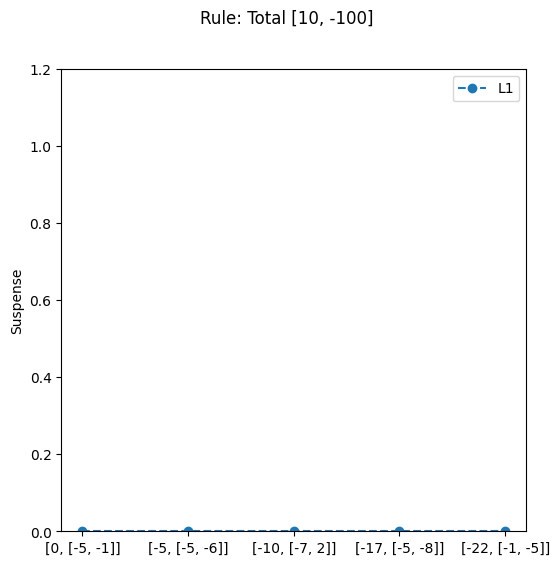

In [88]:
plotSingleSuspenseModelCardPair(low_slice.iloc[0].to_dict())

In [73]:
high_slice.iloc[5].L1, high_slice.iloc[5].pairSequence, np.cumsum(high_slice.iloc[5].pairSequence, axis=0)

([0.49763755525072395,
  0.326474622770919,
  0.6790123456790123,
  0.4444444444444444,
  1],
 array([[ 7, -9],
        [ 0, -9],
        [-9,  9],
        [ 9, -9],
        [ 1,  7]]),
 array([[  7,  -9],
        [  7, -18],
        [ -2,  -9],
        [  7, -18],
        [  8, -11]]))

In [207]:
mid_slice.iloc[0]

suspense         {'L1': [0.3964334705075445, 0.0, 0.16049382716...
rank                                                     47.619048
bounds                                                  [10, -100]
nmax                                                             5
deck                                [3, -3, -1, 6, 9, 0, 6, 5, -3]
isBust                                                       False
pairSequence          [[6, -3], [6, 6], [6, -1], [-1, 3], [6, -3]]
isWin                                                           -1
seenCards                                         [6, 6, 6, -1, 6]
probOfWinning    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
suspenseOrder    {'L1': [5.0, 2.0, 4.0, 2.0, 2.0], 'toBoundary'...
L1               [0.3964334705075445, 0.0, 0.16049382716049382,...
L1-Z             [1.1157360399989096, -0.6886664023305161, 0.04...
L1-Z-mean                                                -0.181686
Name: 67, dtype: object

In [91]:
np.mean(df.explode('L1')['L1']), np.std(df.explode('L1')['L1'])

(0.11886673254445466, 0.19734535391737412)

In [52]:
# Save both as JSONs for JS
bottom10["game"].tolist()

[{'bounds': [21, -100],
  'nmax': 5,
  'deck': array([ 1, -2, -3,  2,  0,  2, -1,  4, -4]),
  'isBust': False,
  'pairSequence': array([[-1,  1],
         [-1,  0],
         [ 2, -2],
         [-2,  2],
         [ 1,  4]]),
  'isWin': 1,
  'seenCards': [-1, -1, 2, -2, 1],
  'probOfWinning': [-20    1
   -19    1
   -18    1
   -17    1
   -16    1
   -15    1
   -14    1
   -13    1
   -12    1
   -11    1
   -10    1
   -9     1
   -8     1
   -7     1
   -6     1
   -5     1
   -4     1
   -3     1
   -2     1
   -1     1
    0     1
    1     1
    2     1
    3     1
    4     1
    5     1
    6     1
    7     1
    8     1
    9     1
    10    1
    11    1
    12    1
    13    1
    14    1
    15    1
    16    1
    17    1
    18    1
    19    1
    20    1
   dtype: int64,
   -16    1.0
   -15    1.0
   -14    1.0
   -13    1.0
   -12    1.0
   -11    1.0
   -10    1.0
   -9     1.0
   -8     1.0
   -7     1.0
   -6     1.0
   -5     1.0
   -4     1.0
   -3     1.0
   -2

In [65]:
bottom10[["pairSequence", "deck"]].to_json("savedDecks/bottom10.json")
top5[["pairSequence", "deck"]].to_json("savedDecks/top5.json")

In [75]:
bottom10[["pairSequence", "deck"]]

,pairSequence,deck
2546,"[[-5, -1], [-5, -6], [-7, 2], [-5, -8], [-1, -5]]","[2, -5, -5, -1, -7, -7, -6, -9, -8]"
3951,"[[-1, -5], [-4, -1], [-4, -5], [-9, 0], [-1, -7]]","[-4, -3, -1, -6, -9, -7, 0, -5, 1]"
2201,"[[-3, -4], [1, 0], [0, 1], [-4, -8], [1, -8]]","[-9, 1, -7, 0, 5, 1, -8, -4, -3]"
51,"[[-6, -3], [-9, -5], [-9, -9], [-9, 0], [-6, -5]]","[4, -6, -9, -5, -3, -9, -2, -5, 0]"
3828,"[[-9, -8], [-4, -4], [-4, -9], [-1, -9], [-4, ...","[-3, -8, -9, -4, 0, -4, 2, 5, -1]"
3068,"[[-8, -9], [-5, -9], [-6, 1], [-5, -8], [-5, 3]]","[3, -8, -3, -9, 1, -6, -5, -5, 1]"
3074,"[[-4, 0], [-6, 2], [-6, -3], [1, 2], [-4, 1]]","[-4, -6, -8, -1, 1, 2, -1, -3, 0]"
2815,"[[-3, -4], [-9, -5], [-9, -4], [-5, 9], [-6, -4]]","[-3, 9, 9, -6, -5, -9, -4, -5, -4]"
2181,"[[-5, -8], [-6, -8], [-6, -9], [-6, -1], [-1, ...","[-6, -9, 0, -7, -9, -1, 2, -8, -5]"
313,"[[-7, -9], [-1, 4], [-1, -3], [4, -9], [-3, 4]]","[-8, 4, -6, -3, -1, -9, 4, -7, 2]"


In [67]:
top5.loc[2398]

suspense         {'L1': [0.2978204541990549, 0.3991769547325103...
rank                                                     99.299475
bounds                                                  [21, -100]
nmax                                                             5
deck                                  [7, 3, 2, 9, 3, 6, 1, -4, 8]
isBust                                                       False
pairSequence             [[2, 8], [1, 8], [9, 7], [7, 3], [-4, 8]]
isWin                                                            1
seenCards                                         [2, 1, 9, 7, -4]
probOfWinning    [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
suspenseOrder    {'L1': [2.0, 4.0, 1.0, 3.0, 5.0], 'toBoundary'...
Name: 2398, dtype: object